# Dfsu - Connectivity

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mikeio

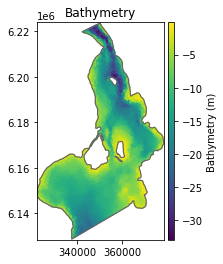

In [2]:
ds = mikeio.read("../tests/testdata/oresundHD_run1.dfsu")
ds.geometry.plot();

The info on the connectivity between nodes and elements can be found in the element table

In [3]:
et = ds.geometry.element_table
len(et)

3612

In [4]:
et[0]

array([718, 229, 143])

Let's find out if any of these nodes are also found in another element, this would imply that these elements are neigbours (adjacent).

In [5]:
for i, e in enumerate(et):
    for n in et[0]:
        if n in e:
            print(f"Node: {n} found in element {i}")

Node: 718 found in element 0
Node: 229 found in element 0
Node: 143 found in element 0
Node: 229 found in element 701
Node: 718 found in element 743
Node: 143 found in element 765
Node: 143 found in element 973
Node: 718 found in element 974
Node: 718 found in element 2000
Node: 229 found in element 2000
Node: 229 found in element 2080
Node: 718 found in element 2081
Node: 718 found in element 2982
Node: 143 found in element 2982


In [6]:
ne = ds.geometry.n_elements

In [7]:
nodetable = {}
for el in range(ds.geometry.n_elements):
    nodes = et[el]

    for node in nodes:
        if node in nodetable:
            nodetable[node].append(el)
        else:
            nodetable[node] = [el]

In [8]:
def is_neighbour(a, b) -> bool:
    return len(set(a).intersection(set(b))) == 2

In [9]:
# create table with neighbours
ec = {}
for el in range(ne):
    nodes = et[el] # nodes in this element

    for n in nodes:
        elements = nodetable[n] # elements that has this node 
        for e in elements:
            if is_neighbour(et[el], et[e]):
                if el in ec:
                    if e not in ec[el]:
                        ec[el].append(e)
                else:
                    ec[el] = [e]

In [10]:
ec[1772]

[1053, 1769, 1773]

## Neighbours

In [11]:
coords = ds.geometry.element_coordinates
e1 = ds.geometry.find_nearest_elements(x=340000,y=6.16e6)
e1

1722

In [12]:
e1_n = ec[e1]
e1_n

[1720, 3125, 1717]

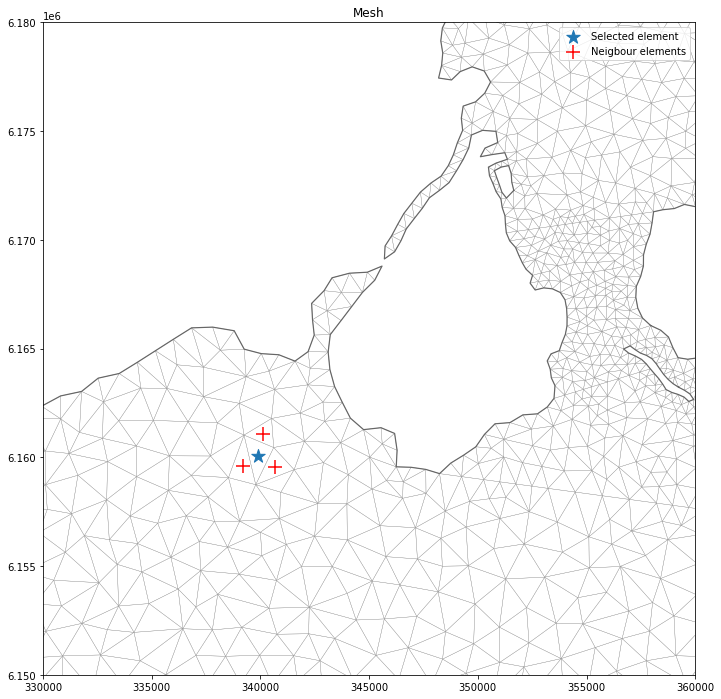

In [13]:
ax = ds.geometry.plot.mesh(figsize=(12,12))
plt.xlim(330000,360000)
plt.ylim(6.15e6,6.18e6)
plt.scatter(coords[e1,0], coords[e1,1], marker='*', s=200, label="Selected element")
plt.scatter(coords[e1_n,0], coords[e1_n,1], marker='+',c='red', s=200, label="Neigbour elements")
plt.legend()

## Shortest path

In [14]:
ea = ds.geometry.find_nearest_elements(x=343000,y=6168000)
eb = ds.geometry.find_nearest_elements(x=365000,y=6168000)

In [15]:
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.csgraph import shortest_path

D = lil_matrix((ne, ne))
for i in range(ne):
    row = ec[i]
    for j in row:
        d = np.sqrt(
            (coords[i,0] - coords[j,0]) ** 2 + (coords[i,1] - coords[j,1]) ** 2
        )
        D[i, j] = d
D = csr_matrix(D)
dist, pred = shortest_path(D, return_predecessors=True)

In [16]:
dist[ea,eb]

39874.190780865974

The predessors matrix `pred` encodes the previous step in the shortest path between any node (in this respect a node in the graph is an element) in the graph.
In order to get all steps in the path between two elements we can loop through the steps.

In [17]:
path = [eb] # the destination
n = eb
while n != ea: # when we reach the start, we are done
    n = pred[ea,n] # walk backwards
    path.append(n)

path[0:10]

[3375, 2225, 3376, 2873, 2556, 2872, 2555, 2560, 39, 84]

The path between two elements is here to illustrate how the distance along the shortest path is calculated, you don't need to use the `pred` matrix if you are only interested in the distance.

Calculate the distance through air (ignoring land).

In [18]:
euc_dist = np.sqrt(np.sum((coords[ea,:2] - coords[eb,:2])**2))

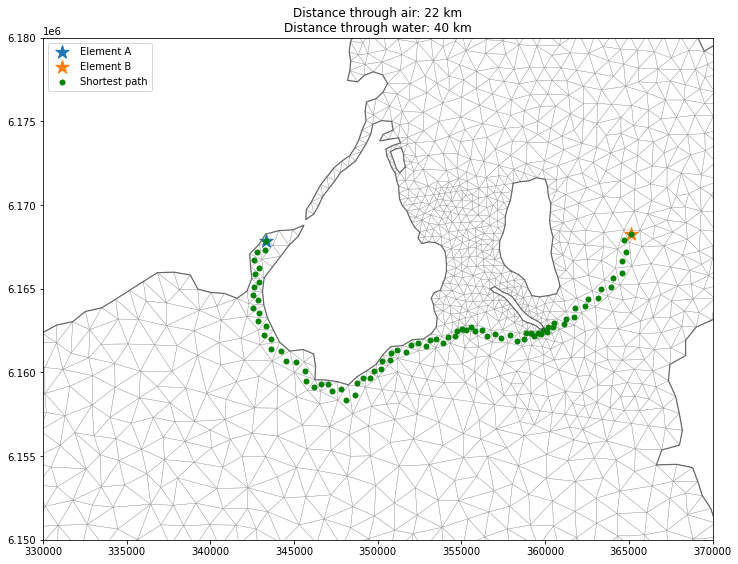

In [19]:
ax = ds.geometry.plot.mesh(figsize=(12,12), title=f"Distance through air: {euc_dist/1000:.0f} km\nDistance through water: {dist[ea,eb]/1000:.0f} km")
plt.xlim(330000,370000)
plt.ylim(6.15e6,6.18e6)
plt.scatter(coords[ea,0], coords[ea,1], marker='*', s=200, label="Element A")
plt.scatter(coords[eb,0], coords[eb,1], marker='*', s=200, label="Element B")
plt.scatter(coords[path,0], coords[path,1], marker='.',c='green', s=100, label="Shortest path")
plt.legend()

## Clustering

In [20]:
# Create sparse connectivity matrix
C = lil_matrix((ne, ne))
for i in range(ne):
    row = ec[i]
    for j in row:
        C[i, j] = 1

In [21]:
ds

<mikeio.Dataset>
Geometry: Dfsu2D
Dimensions: (time:5, element:3612)
Time: 2018-03-07 00:00:00 - 2018-03-11 00:00:00 (5 records)
Items:
  0:  Surface elevation <Surface Elevation> (meter)
  1:  Total water depth <Water Depth> (meter)
  2:  U velocity <u velocity component> (meter per sec)
  3:  V velocity <v velocity component> (meter per sec)

In [22]:
data = ds.Surface_elevation.values.T
data.shape

(3612, 5)

In [23]:
from sklearn.cluster import AgglomerativeClustering

c = AgglomerativeClustering(
            n_clusters=10, connectivity=C, linkage="ward"
    ).fit(data)

In [24]:
c.labels_

array([8, 9, 7, ..., 0, 0, 0], dtype=int64)

In [25]:
da = mikeio.DataArray(c.labels_, geometry=ds.geometry, item="Cluster #")
da

<mikeio.DataArray>
Name: Cluster #
Geometry: Dfsu2D
Dimensions: (element:3612)
Time: 2018-01-01 00:00:00 (time-invariant)

<AxesSubplot:title={'center':'2018-01-01 00:00:00'}>

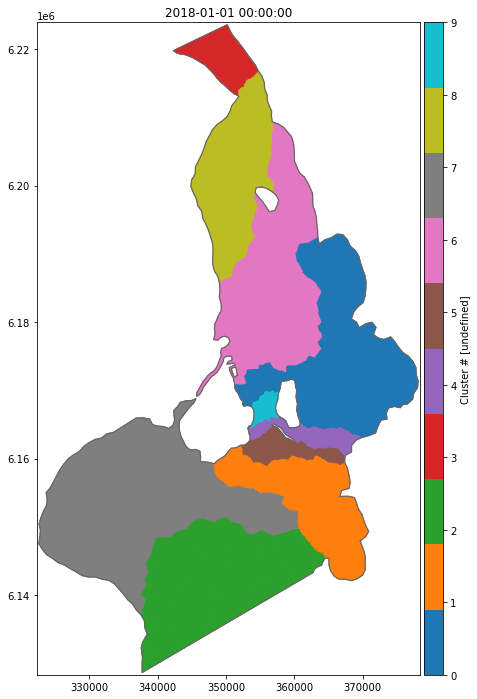

In [26]:
da.plot(figsize=(12,12), cmap='tab10')